# 딥러닝 온라인 심화반 <Level 6>에 오신 것을 환영합니다!

<Level 6>의 주제는 <U>Multi Layer Perceptron(다층 퍼셉트론)</U>입니다. 기존에 배웠던 퍼셉트론(Perceptron)은 강력한 알고리즘이지만, 몇 가지 문제점을 갖고 있습니다. 이번 시간에는 퍼셉트론이 가지고 있는 가장 큰 문제점 중 하나인 **XOR Problem**에 대해 살펴보고, 이를 해결할 수 있는 다양한 방법, 그리고 이 방법을 활용해 퍼셉트론에 Hidden Layer(은닉층)이라는 개념을 도입해서 성능을 획기적으로 개선한 **Multi Layer Perceptron(다층 퍼셉트론)**에 대해서 살펴봅니다. 마지막으로 앞서 다룬 우편번호 손글씨 이미지(MNIST)를 인식하는 퍼셉트론 알고리즘을 Multi Layer Perceptron으로 업그레이드 해보겠습니다.

<U>**Keywords:** XOR Problem, Multi Layer Perceptron, Backpropagation</U>

## XOR Problem

XOR 문제에서 XOR이란 [Exclusive OR](https://en.wikipedia.org/wiki/Exclusive_or) 또는 배타적 논리합을 뜻합니다. 두 개의 명제 x1, x2를 입력 받았다고 가정해보죠. 이에 대해 가능한 논리적 연산으로는 **AND**(x1과 x2 모두 참) 혹은 **OR**(x1 또는 x2가 참) 등이 있을 것입니다. **XOR** 문제는 x1과 x2 중 하나만 참일 때 output을 True로 갖습니다.

<img src="https://drive.google.com/uc?export=view&id=1hYIwH5DISYBwOTdEiD6I9keWyubpXuNM" style="height:250px">

XOR 문제와 AND, OR 문제의 차이점이 보이시나요? AND, OR 문제의 경우 경계선을 그릴 수 있는 반면, XOR 문제는 그릴 수 없습니다. 이러한 특징을 또한 ***Linear separability(선형 분리가능성)***라고도 부릅니다. 앞서 퍼셉트론이 간단한 형태의 Binary Linear Classifier(이진 선형 분류기)로도 볼 수 있다고 하였습니다. 이는 곧 퍼셉트론으로는 XOR 문제와 같은 비선형 문제를 풀지 못한다는 뜻일 것입니다. 이제 XOR 문제 상황을 자세히 들여다보고, 퍼셉트론 알고리즘이 작동하지 않음을 확인해본 다음, 다른 가능한 대안들을 살펴보겠습니다.

## Generate Dataset

### AND

순서대로 **1) AND, 2) OR 그리고 3) XOR** 문제를 풀어보겠습니다. 문제 상황은 다음과 같습니다. 우리에게는 입력값 X가 있는데, 이는 두 개의 변수 X1과 X2로 이루어져 있습니다. 또한 각각 1(True) 또는 0(False)의 값을 가질 수 있습니다. 즉 X1과 X2가 취할 수 있는 경우의 수는 총 2x2 = 4가지입니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
and_data = [
    {'x1' : 0, 'x2' : 0, 'y' : 0},
    {'x1' : 0, 'x2' : 1, 'y' : 0},
    {'x1' : 1, 'x2' : 0, 'y' : 0},
    {'x1' : 1, 'x2' : 1, 'y' : 1},
]

and_data = pd.DataFrame(and_data)
and_data

,x1,x2,y
0,0,0,0
1,0,1,0
2,1,0,0
3,1,1,1


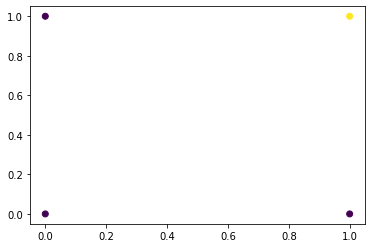

In [3]:
plt.scatter(and_data['x1'], and_data['x2'], c = and_data['y'])

### OR

In [4]:
or_data = [
    {'x1' : 0, 'x2' : 0, 'y' : 0},
    {'x1' : 0, 'x2' : 1, 'y' : 1},
    {'x1' : 1, 'x2' : 0, 'y' : 1},
    {'x1' : 1, 'x2' : 1, 'y' : 1},
]

or_data = pd.DataFrame(or_data)
or_data

,x1,x2,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,1


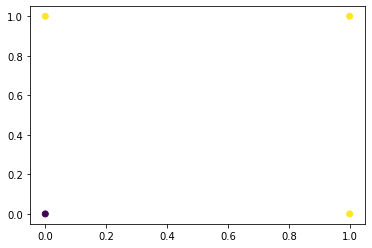

In [5]:
plt.scatter(or_data['x1'], or_data['x2'], c = or_data['y'])

### XOR

In [6]:
xor_data = [
    {'x1' : 0, 'x2' : 0, 'y' : 0},
    {'x1' : 0, 'x2' : 1, 'y' : 1},
    {'x1' : 1, 'x2' : 0, 'y' : 1},
    {'x1' : 1, 'x2' : 1, 'y' : 0},
]

xor_data = pd.DataFrame(xor_data)
xor_data

,x1,x2,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


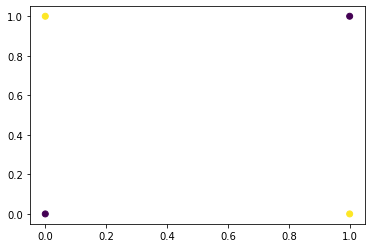

In [7]:
plt.scatter(xor_data['x1'], xor_data['x2'], c = xor_data['y'])

## Gradient Descent

기존의 **퍼셉트론(Perceptron)** 또는 Single Layer Neural Network로 AND, OR, XOR 문제를 해결할 수 있을까요? 다음의 `gradient_descent` 알고리즘으로 직접 보일 것입니다. 이를 위해 <U>퍼셉트론의 개념을 다시 떠올려봅시다.</U> (단층) 퍼셉트론은 하나의 층(layer)으로, 층은 하나 이상의 노드(Node)들로 이루어져 있습니다. 이때 노드는 (1) 입력값(input)을 가중치(weight)와 곱한 값들을 모두 더한 값(내적/합성곱/스칼라곱 연산)이 (2) Activation function(활성함수)에 의해 판단된다고 하였습니다. 우리는 Activation function으로 `sigmoid`를 사용할 것입니다. sigmoid의 출력값이 임계치보다 크면 뉴런이 활성화됩니다.
- `sigmoid`: 미지수 x를 입력 받아 sigmoid(x)를 출력합니다.

### Define Sigmoid

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

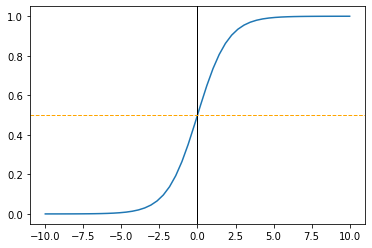

In [9]:
# sigmoid 함수는 다음과 같은 S자형 함수입니다.
xx = np.linspace(-10, 10) # start=-10, stop=10
yy = sigmoid(xx)
plt.plot(xx, yy)

# -1과 1사이의 값을 갖고, y절편은 0.5입니다.
plt.axvline(x=0, color="black", linewidth=1) 
plt.axhline(y=0.5, linestyle='--', color="orange", linewidth=1)
plt.show()

### Perceptron

이제 본격적으로 학습을 시작해봅시다. 두 개의 변수 x1과 x2가 주어졌으니 총 세 개의 값, w1, w2, b를 학습해야 합니다. 보다 일반적인 경우까지 포괄할 수 있는 함수를 만들어봅시다. `gradient_descent` 함수는 X, y와 num_epoch, learning_rate를 입력받으면 경사하강법에 따라 학습을 진행합니다. 먼저 X의 shape에 따라 num_features가 정해지고, w는 이를 size로 가질 것입니다. 다음으로 우리가 학습해야 하는 w와 b를 정의해줍니다. 앞에서 정의해준 `sigmoid`를 활성화함수로, 입력 받은 값을 각각 num_epoch과 learning_rate로 갖습니다. 정확도가 1에 도달할 때까지 모든 epoch에 대해 학습하도록 하겠습니다.
- `gradient_descent`: X, y와 num_epoch, learning_rate를 입력 받아 경사하강법에 따라 학습을 진행합니다.

In [10]:
def gradient_descent(X, y, num_epoch=100, learning_rate=1.0):
    
    # 입력된 X.shape은 (num of rows, num of cols)로 구성됩니다.
    # 퍼셉트론 알고리즘은 X와 y를 transpose하여 사용합니다.
    X = X.T
    y = y.T
    
    # transpose 이전에는 열들의 개수가 즉 X.shape[1]가 feature의 수였습니다.
    # 이후에는 행들의 개수, 즉 X.shape[0]가 feature의 수입니다.
    num_features = X.shape[0]
    
    # 샘플 수도 저장해줍니다.
    num_data = X.shape[1]

    # 우리가 학습해야하는 값들을 먼저 정의해줍니다.
    w = np.random.uniform(low=-1.0, high=1.0, size=num_features) # 위 num_features가 w의 size입니다.
    b = np.random.uniform(low=-1.0, high=1.0)

    # 학습 시작!
    for epoch in range(num_epoch):
        # 먼저 합성곱을 해준 다음, 시그모이드 함수에 넣어줍니다.
        y_predict = np.dot(w, X) + b
        y_predict = sigmoid(y_predict)

        # 이 단계에서 예측값은 0에서 1 사이 연속된 값을 갖는 확률입니다. 
        # 0 또는 1로 이진분류하기 위해 threshold를 0.5로 해줍니다.
        # 곧 예측한 확률이 50%보다 크다면 y가 1일 것이라고 생각하는 거죠.
        predict = y_predict > 0.5
        accuracy = (predict == y).mean()

        # 매번 학습 경과를 출력합니다.
        print("{0} accuracy = {1:.5f}".format(epoch, accuracy))

        # 정확도가 1에 도달할 때까지 학습합니다.
        if accuracy == 1.00:
            break

        # 경사하강법에 따라 비용함수를 최소화하도록 각 값들을 갱신해줍니다
        w = w - learning_rate * np.dot((y_predict - y), X.T) / num_data
        b = b - learning_rate * (y_predict - y).mean(axis=0)

    return w, b, accuracy

## XOR 문제 해결하기

위에서 퍼셉트론 알고리즘을 `gradient_descent`로 구현하였습니다. 이제 **1) AND, 2) OR 그리고 3) XOR** 문제를 풀어보겠습니다. 각각의 경우 X와 y를 생성한 다음, num_epoch과 learning_rate는  기본값인 100과 1.0으로 두고, `gradient_descent` 함수에 투입해줌으로써 w, b, accuracy를 출력받습니다.

### AND

In [11]:
data = and_data

X = data[['x1', 'x2']].values  # values : np.array, 2차원 array
y = data['y'].values

w, b, accuracy = gradient_descent(X, y)

0 accuracy = 0.75000
1 accuracy = 0.75000
2 accuracy = 0.75000
3 accuracy = 0.75000
4 accuracy = 0.75000
5 accuracy = 0.75000
6 accuracy = 0.75000
7 accuracy = 0.75000
8 accuracy = 0.75000
9 accuracy = 0.75000
10 accuracy = 1.00000


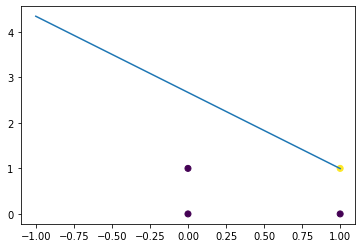

In [12]:
plt.scatter(data['x1'], data['x2'], c = data['y'])

xx = np.linspace(-1, +1)
yy = -(w[0] * xx + b) / w[1]

plt.plot(xx, yy)

### OR

In [13]:
data = or_data

X = data[['x1', 'x2']].values  # values : np.array, 2차원 array
y = data['y'].values

w, b, accuracy = gradient_descent(X, y)

0 accuracy = 0.75000
1 accuracy = 0.75000
2 accuracy = 0.75000
3 accuracy = 0.75000
4 accuracy = 0.75000
5 accuracy = 0.75000
6 accuracy = 0.75000
7 accuracy = 0.75000
8 accuracy = 0.75000
9 accuracy = 0.75000
10 accuracy = 0.75000
11 accuracy = 0.75000
12 accuracy = 0.75000
13 accuracy = 0.75000
14 accuracy = 0.75000
15 accuracy = 0.75000
16 accuracy = 0.75000
17 accuracy = 0.75000
18 accuracy = 0.75000
19 accuracy = 0.75000
20 accuracy = 0.75000
21 accuracy = 0.75000
22 accuracy = 0.75000
23 accuracy = 1.00000


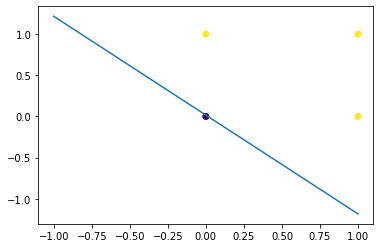

In [14]:
plt.scatter(data['x1'], data['x2'], c = data['y'])

xx = np.linspace(-1, +1)
yy = -(w[0] * xx + b) / w[1]

plt.plot(xx, yy)

### XOR Data

In [15]:
data = xor_data

X = data[['x1', 'x2']].values  # values : np.array, 2차원 array
y = data['y'].values

w, b, accuracy = gradient_descent(X, y)

0 accuracy = 0.50000
1 accuracy = 0.50000
2 accuracy = 0.50000
3 accuracy = 0.50000
4 accuracy = 0.50000
5 accuracy = 0.25000
6 accuracy = 0.25000
7 accuracy = 0.50000
8 accuracy = 0.50000
9 accuracy = 0.50000
10 accuracy = 0.50000
11 accuracy = 0.50000
12 accuracy = 0.50000
13 accuracy = 0.50000
14 accuracy = 0.50000
15 accuracy = 0.50000
16 accuracy = 0.50000
17 accuracy = 0.50000
18 accuracy = 0.50000
19 accuracy = 0.50000
20 accuracy = 0.50000
21 accuracy = 0.50000
22 accuracy = 0.50000
23 accuracy = 0.50000
24 accuracy = 0.50000
25 accuracy = 0.50000
26 accuracy = 0.50000
27 accuracy = 0.50000
28 accuracy = 0.50000
29 accuracy = 0.50000
30 accuracy = 0.50000
31 accuracy = 0.50000
32 accuracy = 0.50000
33 accuracy = 0.50000
34 accuracy = 0.50000
35 accuracy = 0.50000
36 accuracy = 0.50000
37 accuracy = 0.50000
38 accuracy = 0.50000
39 accuracy = 0.50000
40 accuracy = 0.50000
41 accuracy = 0.50000
42 accuracy = 0.50000
43 accuracy = 0.50000
44 accuracy = 0.50000
45 accuracy = 0.5000

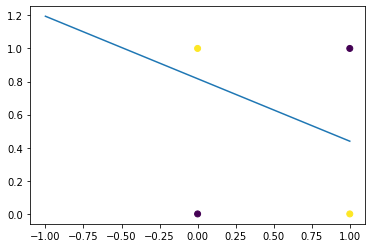

In [16]:
plt.scatter(data['x1'], data['x2'], c = data['y'])

xx = np.linspace(-1, +1)
yy = -(w[0] * xx + b) / w[1]

plt.plot(xx, yy)

기존 퍼셉트론 알고리즘으로 AND, OR 문제는 해결할 수 있으나, XOR 문제를 해결할 수 없었습니다. 그렇다면 XOR 문제를 해결하려면 어떻게 해야 할까요? <U>본격적으로 Multi Layer Perceptron을 다루기에 앞서, 다른 가능한 해결 방안들을 떠올려봅시다.</U>

### XOR (Transformed)

XOR 문제에서 문제가 되었던 것이 ***Linear separability(선형 분리가능성)***였는데요. 그렇다면 선형적으로 분리가능하도록 데이터를 변형해준다면 어떨까요? 퍼셉트론의 연산을 통해 얻은 어떠한 출력값을, 다른 퍼셉트론의 입력값으로 사용하는 것이죠. 이전 층에서 선형결합을 한 뒤, 비선형 활성화함수(이를테면 sigmoid)를 거친 값을 입력 받았다면, 그 값들의 XOR 연산에 대해서는 경계선을 그릴 수 있지 않을까요? 바로 아래 그림처럼요.

<img src="https://dmm613.files.wordpress.com/2014/09/non_linearly_separable_problem_xor.png" style="height:300px">

<p style='text-align: right;'>(출처: https://dmm613.wordpress.com/2014/09/22/artificial-neural-networks-part-1/)</p>

In [17]:
x1 = xor_data['x1']
x2 = xor_data['x2']
y = xor_data['y']

x1_flipped = (x1 == 0).astype('int')
x2_flipped = (x2 == 0).astype('int')

x1_transformed = x1_flipped & x2
x2_transformed = x1 & x2_flipped

xor_transformed = {'x1' : x1_transformed, 'x2' : x2_transformed, 'y' : y}
xor_transformed = pd.DataFrame(xor_transformed)

xor_transformed

,x1,x2,y
0,0,0,0
1,1,0,1
2,0,1,1
3,0,0,0


In [18]:
data = xor_transformed

X = data[['x1', 'x2']].values  # values : np.array, 2차원 array
y = data['y'].values

w, b, accuracy = gradient_descent(X, y)

0 accuracy = 0.50000
1 accuracy = 0.50000
2 accuracy = 0.75000
3 accuracy = 0.75000
4 accuracy = 0.75000
5 accuracy = 0.75000
6 accuracy = 0.75000
7 accuracy = 1.00000


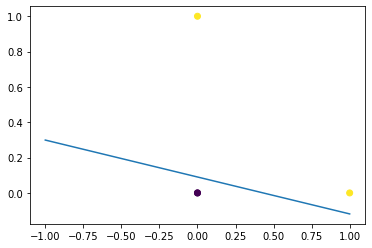

In [19]:
plt.scatter(data['x1'], data['x2'], c = data['y'])

xx = np.linspace(-1, +1)
yy = -(w[0] * xx + b) / w[1]

plt.plot(xx, yy)

첫 번째 해결방안은 data transformation입니다. 기존의 퍼셉트론을 이용해 선형 경계선을 그릴 수 있는 형태로 데이터를 변환시키는 것이죠. 그러나 데이터를 transform하는 규칙을 직접 찾아야 하기 때문에, 사실상 머신러닝 알고리즘을 쓰는 의미가 없습니다.

***<center>(1) Transform의 단점: 데이터를 transform하는 규칙을 직접 찾아야 한다!</center>***

### XOR data (Polynomial)

In [20]:
x1 = xor_data['x1']
x2 = xor_data['x2']
x3 = x1 * x1
x4 = x1 * x2
x5 = x2 * x2

y = xor_data['y']

polynomial_xor_data = {
    'x1' : x1,
    'x2' : x2,
    'x3' : x3,
    'x4' : x4,
    'x5' : x5,
    'y' : y,
}

polynomial_xor_data = pd.DataFrame(polynomial_xor_data)
polynomial_xor_data

,x1,x2,x3,x4,x5,y
0,0,0,0,0,0,0
1,0,1,0,0,1,1
2,1,0,1,0,0,1
3,1,1,1,1,1,0


In [21]:
data = polynomial_xor_data

X = data[['x1', 'x2', 'x3', 'x4', 'x5']].values  # values : np.array, 2차원 array
y = data['y'].values

w, b, accuracy = gradient_descent(X, y)

# polynomial은 시각화를 할 수 없다. 3차원을 넘어가기 때문. 
# 이 경우는 5차원..... ㅠ

0 accuracy = 0.75000
1 accuracy = 0.75000
2 accuracy = 0.75000
3 accuracy = 0.75000
4 accuracy = 0.75000
5 accuracy = 0.75000
6 accuracy = 0.75000
7 accuracy = 0.75000
8 accuracy = 0.75000
9 accuracy = 0.75000
10 accuracy = 0.75000
11 accuracy = 0.75000
12 accuracy = 0.75000
13 accuracy = 0.75000
14 accuracy = 0.75000
15 accuracy = 0.75000
16 accuracy = 0.75000
17 accuracy = 0.75000
18 accuracy = 0.75000
19 accuracy = 0.75000
20 accuracy = 0.75000
21 accuracy = 0.75000
22 accuracy = 0.75000
23 accuracy = 1.00000


두 번째 해결방안은 polynomial입니다. 비선형 관계성을 반영하기 위해 기존 데이터의 이차항을 추가해주는 것입니다. 그런데 X의 feature 수가 굉장히 많다고 생각해보세요. Polynomial 방법을 쓴다면 feature의 수가 제곱으로 늘어나게 됩니다.

***<center>(2) Polynomial의 단점: Feature의 수가 제곱으로(기하급수적으로) 늘어난다!</center>***

## 다층 퍼셉트론 (Multi Layer Perceptron)

### Multi Layer Perceptron 소개

이제 구조적으로 퍼셉트론 알고리즘을 개선하고자 합니다. XOR 문제를 해결하기 위해 고안된 방법이 바로 **Multi Layer Perceptron (MLP 또는 다층 퍼셉트론)**인데요. 기존 퍼셉트론에서는 input과, 그것들의 가중합으로 얻은 output만이 존재했습니다. 여기에는 (뉴런과 더불어) 어떤 노드가 활성화된다는 신호(signal) 개념이 지배적이었습니다. 그런데 MLP에서는 층(layer)을 하나 더 쌓는다는 개념이 새롭게 등장합니다. 바로 **Hidden layer(은닉층)**입니다. 이제 우리의 신경망은 <U>Input layer(입력층), Hidden layer(은닉층), Output layer(출력층)</U>의 3단 구조로 이루어져 있습니다.

<img src="https://drive.google.com/uc?export=view&id=1p6hGtKut1UhaRKu_nIOFhBUwYHM7mvXj" style="height:300px">

앞서 XOR 문제를 해결하기 위해 Transform, Polynomial의 두 가지 방법을 살펴보았습니다. 각각 (1) 직접 transformation rule을 찾아야 한다 (2) feature의 수가 제곱으로 늘어난다는 단점 또한 알아보았습니다. MLP에서는 hidden layer를 투입함으로써 이를 해결합니다. 신경망의 앞쪽(input layer -> hidden layer)이 X에서 새로운 feature를 뽑아내는 역할을 하고, 뒤쪽이 우리가 알고 있는 퍼셉트론입니다. 은닉층이 일종의 다리 역할을 하여 비선형 조합을 가능하게 하는 것이죠. 그리하여 ***(1) X의 feature을 찾아내는 rule을 스스로 찾고, (2) feature(즉 노드)의 수를 우리가 조절할 수 있게 됨***으로써 두 개의 단점은 MLP의 장점이 되었습니다. 결론적으로 MLP은 두 가지 해결방안의 단점을 구조적으로 개선한 모형입니다.

그리고 hidden layer가 2개 이상인 경우 **DNN(Deep Neural Network) 또는 심층신경망**이라고 부릅니다. 이를 아주 ***깊게(Deep)***, 또 노드의 수를 증가시켜 ***넓게*** 쌓을 수도 있습니다. 우리가 배우는 **Deep Learning** 또한, DNN 구조의 인공신경망(Artificial Neural Network)에 관한 알고리즘을 일컫는 말이기도 합니다. 이러한 관점에서 hidden layer는 딥러닝을 정의하는 핵심적인 개념입니다. 다음으로 다룰 내용은 MLP가 예측하고(forward), 학습하는(back) 방식입니다.

### 순전파 (Forward propagation)

그렇다면 MLP를 구현해 XOR 문제를 풀어보겠습니다. 여기에는 **Forward propagation(순전파)** 알고리즘이 사용됩니다. Input을 가지고 output까지 연산하는 과정을 Forward 또는 [Feed-forward](https://en.wikipedia.org/wiki/Feedforward_neural_network) propagation*(i.e. Inputs are fed directly to the outputs)*이라고 합니다. 입력값에서 출력값에 이르기까지 정보의 전달이 순방향으로 이루어지는 것이죠. 아래 그림에서 <font color='green'>**초록색 화살표**</font>가 그 방향을 의미하며, 이 과정을 거쳐 우리는 x를 가지고 y의 예측값을 구할 수 있습니다. 여기서 원은 노드(Node)를 의미합니다. ***모든*** 노드들이 ***한쪽 방향*** 으로만 연결되어 있음을 확인할 수 있습니다. 

<img src="https://drive.google.com/uc?export=view&id=1xMZ03HQfjsuhwtVaiLpkdivfjlBk4Uay" style="height:300px">

참고로 노드들은 한 방향이 아니라 순환적인 구조를 가질 수도 있고, 모든 노드들이 서로 연결되어 있지 않을 수도 있습니다. 전자는 **RNN(Recurrent Neural Network) 또는 순환신경망**에, 후자는 **CNN(Convolutional Neural Network) 또는 합성곱 신경망**에 해당하며, 각각 <Level 9>와 <Level 10>에서 다룹니다.

그렇다면 XOR 문제 상황으로 돌아가봅시다. 앞서 사용한 데이터를 다시 불러옵니다.

In [22]:
data = xor_data
data

,x1,x2,y
0,0,0,0
1,0,1,1
2,1,0,1
3,1,1,0


In [23]:
x = data[['x1', 'x2']].values
y = data['y'].values

x.shape, y.shape

((4, 2), (4,))

In [24]:
y = y.reshape(4, 1)

x.shape, y.shape

((4, 2), (4, 1))

XOR 문제를 해결하기 위해 아래과 같은 다층 퍼셉트론을 만들었습니다.  1개의 input layer, 1개의 hidden layer, 1개의 output layer로 이루어진 구조이며, 이때 hidden layer의 노드의 수는 3개로 지정하였습니다. 앞선 그림들에 추가로 1이 그려진 원, 즉 Bias Node들을 도식화하였습니다. 이제 X와 w, b들을 가지고 순전파를 통해 예측값을 낼 것입니다. 이때 (1) input layer에서 hidden layer (2) hidden layer에서 output layer로 연결되는 두 쌍의 w와 b에 대해 학습이 필요합니다. <U>그렇다면 w와 b의 size은 어떻게 될지 생각해봅시다.</U>

<img src="https://drive.google.com/uc?export=view&id=1crcQEygdgQpSzU14Qfl3Pq8CzVydo5Xh" style="height:350px">

1. **input layer -> hidden layer:** w1 = (2, 3), b1 = (1, 3)

    - input layer에는 x1, x2의 2개 변수들이 있으므로 2개의 노드가 있습니다.
    - 지정한 대로 hidden layer에는 3개의 노드가 있습니다.


2. **hidden layer -> output layer:** w2 = (3, 1), b2 = (1, 1)
    - output layer에는 1개의 노드가 있습니다. 연산을 통해 $(-\infty, \infty)$ 사이의 하나의 값을 낼 것입니다.
    - 이 값을 가지고 시그모이드 연산을 통해 y에 대한 예측값 h(x)를 낼 것입니다.

### 역전파(Backpropagation)

Forward propagation은 input에서 output까지의 방향으로 연산하여 예측값을 얻는 방법입니다. 그렇다면 신경망의 weight(및 bias)를 학습시키려면 어떻게 해야 할까요? 정반대 방향으로 output에서 input까지 연산을 해나가면 됩니다. 이 방법을 **Backpropagation(역전파)**이라고 합니다. 또한 Multi Layer Perceptron에서는 한 층의 weight가 아닌 여러 층의 weight에 대한 변화량을 구해야 합니다. <U>각각의 층에서 Cost function ***J***에 대해 편미분 연산</U>을 해야 하는 것이죠. <font color='red'>**빨간색 화살표**</font>를 따라가면서 Cost의 미분값이 전달된다고 생각하면, MLP에서 어떻게 학습이 이루어지는지 이해하실 수 있습니다.
<img src="https://drive.google.com/uc?export=view&id=1mOXnTFIAGKJq8PRgWCdR7tQY_ykW-8he" style="height:300px">

이때 중요한 역할을 하는 것이 바로 **Chain rule(연쇄 법칙)**입니다. 쉽게 말해, 미분값을 차례로 계산할 때 각 층에서의 미분값들로 분해할 수 있다는 것입니다. 예를 들어, 우리는 Forward propagation에서 x에 대해 합성곱 연산을 한 결과를 z에, 그리고 Activation function 같은 과정을 거쳐 마지막 예측 결과를 h(x)에 저장합니다. 그렇다면 Cost function ***J***를 x에 대해 미분한 값은 *(1) J를 z에 대해 미분한 값*과 *(2) z를 x에 대해 미분한 값*을 곱한 것입니다.

<U>다시 말해 Cost function의 편미분을 여러 조각을 내서 하나하나 구한 뒤, 이를 곱하는 것이 Backpropation의 핵심입니다.</U> 이처럼 Chain rule을 활용하면 아무리 복잡한 편미분 연산이라도 여러 개로 쪼개어 곱을 구할 수 있습니다. 사실 MLP를 고안했던 Minsky(1969)는 *결코 학습시킬 수 없다(No one earth had found a viable way to train)*고 말했었는데요. Hinton(1986)이 제안한 Backpropagation, 그리고 Chain Rule을 이용해 끝내 학습에 성공했습니다.

앞선 XOR 예제에서 Chain rule을 이용해 학습을 진행해봅시다. 이를 위해 우리가 거친 단계를 생각해보면, (1) 스칼라곱 연산을 통해 X에서 Z를,  (2) `sigmoid`를 이용해 Z에서 A를 얻었습니다. 먼저 `sigmoid` 함수에 대해 미분하면, A/dZ를 구할 수 있을 것입니다.

$$
sigmoid(x) = \frac {1}{1+e^{-x}}
$$

In [25]:
# derivative of sigmoid function
def dsigmoid(A):
    # sigmoid 함수를 미분하면 출력값 * (1-출력값)과 같습니다.
    dA = A * (1 - A)
    return dA

다음으로 우리가 업데이트 해야 할 모수는 W, b의 두 가지입니다. 따라서 W, b 각각에 대해서 미분을 해준 후, 이전 미분값과 곱해주어야겠죠. 다시 적으면 Z/dW, Z/db를 구한 뒤 A/dZ를 곱하면, 해당 레이어에서의 기울기를 얻을 수 있습니다. 이 기울기를 가지고 모수를 업데이트해주면 됩니다. 이때 Loss function으로 이용할 함수는 앞서 다룬 바 있는 **Cross Entropy**이며, 아래와 같이 ***L***로 도식화합니다.

$$
L(y, h({x})) = -y \cdot \log(h({x})) - (1-y) \cdot \log(1-h({x}))
$$

$$
J(W, b) = \frac{1}{m}\sum_{i=1}^{m} {L(y_i, h({x_i}))}
$$

In [26]:
def cross_entropy(actual, predict, eps=1e-15):
    
    # 실제 값과 예측 값을 Numpy 배열로 바꿔줍니다.
    actual = np.array(actual)
    predict = np.array(predict)
    
    # 0이 log에 들어가게 되면 무한대로 발산해버릴 수 있으니 아주 작은 값을 넣어 이를 방지합니다.
    clipped_predict = np.minimum(np.maximum(predict, eps), 1 - eps)
    
    # 실질적인 Loss를 계산합니다
    loss = actual * np.log(clipped_predict) + (1 - actual) * np.log(1 - clipped_predict)
    
    return -1.0 * loss.mean()

이제 우리의 신경망을 학습시켜봅시다. 먼저 적절한 size에 따라 초기화된 w와 b를 생성해줍니다. 이때 `np.random.uniform(-1.0, high=1.0, size)`라는 코드에서 알 수 있듯 -1과 1 사이의 uniform 분포로부터 난수를 생성하였습니다. X와 w,b 사이의 합성곱 및 시그모이드 연산을 통해 순전파를, cost function의 편미분값을 이용해 역전파를 해줍니다. learning rate는 1.0으로 1000번 반복하되, 정확도가 1.0에 다다르면 학습을 멈추겠습니다.

In [27]:
x = x.T
y = y.T

x.shape, y.shape

((2, 4), (1, 4))

학습을 위해 w1, w2, b1, b2를 어떻게 구할 수 있을까요? 각각은 다음과 같이 유도될 수 있는데요. 우리는 d1(빨간 네모)와 d2(파란 네모)를 각각 구한 다음, 그것들을 이용해 w와 b를 계산하겠습니다.여기서 d2는 d1에 어떤 값이 곱해진, 즉 Chain Rule에 의해 미분값이 전달된 것을 확인할 수 있습니다.

<img src="https://drive.google.com/uc?export=view&id=1qDiQoEvqMhTVK1kqjRbj0GFSd36elAYf" style="height:300px">

In [28]:
num_epoch = 1000
learning_rate = 1.0

num_data = x.shape[1]  # x.shape[1] : 4이기 때문에 4 말고 x.shape[1]로 준다.

w1 = np.random.uniform(low = -1.0, high = 1.0, size = (3, 2))  # (x : 2, a1 : 3)
b1 = np.random.uniform(low = -1.0, high = 1.0, size = (3, 1))  # (1, 3)
w2 = np.random.uniform(low = -1.0, high = 1.0, size = (1, 3))
b2 = np.random.uniform(low = -1.0, high = 1.0, size = (1, 1))  # (1, 3)

for epoch in range(num_epoch):
    # Forward-Propagation
    z1 = np.dot(w1, x) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(w2, a1) + b2
    a2 = sigmoid(z2)

    y_predict = a2  # 예측값.
    
    predict = (y_predict >= 0.5).astype('int')
    accuracy = (predict == y).mean()
    
    loss = cross_entropy(y, y_predict)
    
    if epoch % 100 == 0:
        print(f'{epoch:3}, {accuracy:.2f}, {loss:.6}')
        
    if accuracy == 1:
        break
    
    # Back-Proagation
    d2 = a2 - y
    d1 = np.dot(w2.T, d2) * dsigmoid(a1)

    w2 = w2 - learning_rate * np.dot(d2, a1.T) / num_data
    w1 = w1 - learning_rate * np.dot(d1, x.T) / num_data

    b2 = b2 - learning_rate * d2.mean(axis = 1, keepdims = True)
    b1 = b1 - learning_rate * d1.mean(axis = 1, keepdims = True)

print('---' * 10)
print(f'{epoch:3}, {accuracy:.2f}, {loss:.6}')

  0, 0.50, 0.746684
100, 0.75, 0.68935
200, 0.75, 0.638763
------------------------------
295, 1.00, 0.40494


In [32]:
a1.shape, d2.shape, a2.shape, y.shape

((3, 4), (1, 4), (1, 4), (1, 4))

Multi Layer Perceptron을 이용하면 원래의 데이터를 따로 변형해주지 않고도 XOR 문제를 해결할 수 있습니다!

## Wrap-up

이번 <Level 6>에서는 Multi Layer Perceptron(다층 퍼셉트론)을 알아보았습니다. 기존에 배웠던 퍼셉트론(Perceptron)은 강력한 알고리즘이지만, XOR 문제를 해결하지 못하는 문제점이 있었습니다. XOR 문제를 해결하기 위해서는 선형적으로 분리가능하도록 데이터를 변형해주어야 했습니다. 첫 번째 방안은 ***(1) Transformation***으로, 직접 transform하는 규칙을 찾아야 한다는 한계가 있었습니다. 두 번째는 ***(2) Polynomial***으로, polynomial feature들을 추가해주기 때문에 그만큼 feature의 수가 늘어난다는 단점이 있었습니다. 따라서 이를 구조적으로 개선한 **Multi Layer Perceptron**이 필요한 것인데요. MLP는 한 층 이상의 Hidden layer(은닉층)을 쌓음으로써 두 가지 단점을 극복하였습니다. Forward propagation(순전파)로 정답을 예측하고, Backpropagation(역전파)으로 신경망의 weight 및 bias를 학습시킬 수 있었습니다. 이 과정은 Chain rule, 그리고 Cost의 미분값들이 각 노드에 연쇄적으로 전달되는 것과 같습니다.

<Level 6> 수업은 여기까지입니다. 과제로는 우편번호 손글씨 이미지(MNIST)를 인식하는 문제를 Multi Layer Perceptron으로 풀어보겠습니다.

***<center>수고하셨습니다.</center>***